# Manifold

author: steeve.laquitaine@epfl.ch  

**Hypotheses**

* Manifold capacity degradation should be explained by increased radius and dimensions and increased correlation of direction manifolds and vvs.

**method**:

* task parameters (see bbp_workflow config):
    * start delay: 1000 ms
    * stimulus delay: 1500 ms
    * 360 stimuli x 50 repeated trials for characterizing the tuning curves
    * interstimulus interval: 200 ms


* data:
    1. 36 simulation files
    2. bbp_workflow config script spikesorting_stim_rotations.py indicates 36 files with orientations for file 1: 0 to 9, file 2: 10 to 19 etc...
    3. png files confirm point 2): /gpfs/bbp.cscs.ch/project/proj83/scratch/home/isbister/post_physiology_2023/sim_data/campaigns/spikesorting_stimulus_tests/4_spikesorting_stimulus_test_neuropixels_8-1-24/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/35
    5. Thus: Each simulation file is organized as: simulation file duration (101500 ms) = start delay of 1500 ms then 10 repeats of (orientation for 9800 ms followed by 200 ms of ISI)

### Requirements

* https://github.com/schung039/neural_manifolds_replicaMFT.git

### Setup

Setup `cebra_manifold` env

In [1]:
import os
import cebra
from cebra import CEBRA
import torch
import numpy as np
import spikeinterface as si
from matplotlib import pyplot as plt
import pandas as pd
import random
from sklearn.decomposition import PCA  # dimensionality reduction

# set project path
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes import utils
from src.nodes.task import task
from src.nodes.analysis.features import features as feat
from src.nodes.analysis.code import igeom

# DATASET PATHS
data_conf, _ = utils.get_config("silico_neuropixels", "stimulus").values()
GT = data_conf["sorting"]["simulation"]["ground_truth"]["full"]["output"]
K4 = data_conf["sorting"]["sorters"]["kilosort4"]["full"]["output"]

# SAVE PATH
model_path_full_gt = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/analysis/cebra_manifold/cebra_full_gt.pt"
model_path_rand_k4 = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/analysis/cebra_manifold/cebra_rand_k4.pt"
model_path_bias_k4 = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/analysis/cebra_manifold/cebra_bias_k4.pt"
model_path_k4 = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/analysis/cebra_manifold/cebra_k4.pt"

# SETUP PARAMETERS
# select 8 directions out of the 360; (4, 5, 6, fails, 8 worked directions)
SAMPLE_DIR = np.arange(0, 360, 45)
DT = 1.3

# SETUP QUALITY PATH
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_1h.csv"

2024-10-21 09:59:30,634 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-21 09:59:30,719 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Specs

In [6]:
# check for GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__CUDA Device Name:", torch.cuda.get_device_name(0))
    print(
        "__CUDA Device Total Memory [GB]:",
        torch.cuda.get_device_properties(0).total_memory / 1e9,
    )

__CUDNN VERSION: 90100
__Number CUDA Devices: 4
__CUDA Device Name: Tesla V100-SXM2-16GB
__CUDA Device Total Memory [GB]: 16.935419904


### Custom functions

In [110]:
def get_responses_from_path(
    sorting_path: str,
):

    # get neural responses
    # compute unit x stimulus response matrix
    Sorting = si.load_extractor(sorting_path)

    # get task epoch infos
    task_pm = task.get_task_parameters(
        start_delay=500,
        n_orientations=10,
        n_repeats=50,
        stimulus_duration=200,
        n_simulations=36,
    )

    # get stimulus directions and intervals (ms)
    stimulus_intervals_ms = task.get_stimulus_intervals_ms(
        task_pm["epoch_labels"], task_pm["epoch_ms"]
    )
    responses = task.compute_response_by_stim_matrix(
        Sorting.unit_ids, Sorting, stimulus_intervals_ms
    )
    return responses


def get_responses(Sorting):

    # get task epoch infos
    task_pm = task.get_task_parameters(
        start_delay=500,
        n_orientations=10,
        n_repeats=50,
        stimulus_duration=200,
        n_simulations=36,
    )

    # get stimulus directions and intervals (ms)
    stimulus_intervals_ms = task.get_stimulus_intervals_ms(
        task_pm["epoch_labels"], task_pm["epoch_ms"]
    )
    responses = task.compute_response_by_stim_matrix(
        Sorting.unit_ids, Sorting, stimulus_intervals_ms
    )
    return responses


def get_single_units_sortingextractor(sorter, quality_path):
    qd_df = pd.read_csv(quality_path)
    single_unit_ids_k4 = qd_df[qd_df.sorter == sorter].sorted.values
    return si.load_extractor(K4).select_units(single_unit_ids_k4)


def locate_unit_for_in_givenby(
    this_type: pd.DataFrame,
    df_unit: pd.DataFrame,
    type_count,
    seed: int = 0,
    with_replacement=False,
):
    """locate the indices of the N first units
    that match a unit type. N is given by type_count

    Args:
        this_type (pd.DataFrame): 1 row x N cols unit features
        df_unit (_typd.DataFramepe_): ground truth unit (rows) x features (col)
        type_count (_type_): number of occurence of this type among sorted units
        seed (list): seed to reorder indices if bootstrapping
        to sample a different set of ground truth units with
        the same unit type distribution

    Returns:
        _type_: index location of ground truth in df_unit
    """
    # detect the unit type
    flagged_type = df_unit.T.apply(lambda row: all(row.values == this_type)).values

    # locate it
    type_loc = np.where(flagged_type)[0]
    n_types = len(type_loc)

    # random sample unit ids of this type
    # to match its count in the sorted population
    if seed:
        # set reproducibility
        # use random.seed not np.random.seed
        # with random.sample
        random.seed(seed)
        # method 1: sample without replacement
        try:
            ix = random.sample(np.arange(0, n_types, 1).tolist(), type_count)
        except:
            # if type_count > n_types, sample with replacement
            ix = random.choices(np.arange(0, n_types, 1).tolist(), k=type_count)

        # method 2: sample with replacement
        if with_replacement:
            ix = random.choices(np.arange(0, n_types, 1).tolist(), k=type_count)

        type_loc = type_loc[ix]

    # take first type_count units
    # method 1: sample without replacement
    gt_loc = type_loc.tolist()
    # method 2: shuffle without replacement
    # gt_loc = type_loc[:type_count].tolist()
    return gt_loc


def sample_gt_based_on_sorting_distribution(
    sorter, Sorting, SortingTrue, quality_path, dt, seed=None
):
    """sample ground truth units to match sorted single-unit
    distribution. We get N ground truth units from each type
    to match its count in the sorted unit population

    Args:
        sorter (_type_): _description_
        Sorting (_type_): _description_
        SortingTrue (_type_): _description_
        quality_path (_type_): _description_
        dt (_type_): _description_
        seed: seed to reorder indices in case of bootstrapping

    Returns:
        _type_: _description_
    """

    unique_type_feat = ["layer", "synapse", "etype"]
    df_gt = feat.get_unit_features(SortingTrue)

    # get unique types
    unique_type = df_gt.drop_duplicates()

    # count sorted unit types
    df = feat.get_feature_data_for(sorter, Sorting, SortingTrue, quality_path, dt)
    counts = feat.count_unit_type(
        df[unique_type_feat],
        unique_type,
    )

    # sample so as to match sorted single-unit distribution
    # get N ground truth units from that type given by count_k4
    gt_loc = []
    for ix in range(len(unique_type)):
        gt_loci = locate_unit_for_in_givenby(
            unique_type.iloc[ix], df_gt, counts.iloc[ix]["count"], seed=seed
        )
        gt_loc += gt_loci
    gt_id = df_gt.index[gt_loc]

    return {
        "gt_loc": gt_loc,
        "gt_id": gt_id,
        "df_gt": df_gt,
        "counts": counts,
        "unique_type": unique_type,
    }


def sample_units_to_match_sorter_sampling_bias(
    sorter, response, sorting_path, sorting_true_path, dt, seed=0
):

    Sorting = si.load_extractor(sorting_path)
    SortingTrue = si.load_extractor(sorting_true_path)
    data = sample_gt_based_on_sorting_distribution(
        sorter, Sorting, SortingTrue, quality_path, dt, seed=seed
    )

    # unit test gt location indices
    assert all(SortingTrue.unit_ids[data["gt_loc"]] == data["gt_id"]), "should match"

    return response[data["gt_loc"], :]


def sample_units_randomly_to_match_sorter_yield(sorter, response, seed=0):

    # reproducibility
    # use random.seed with random.sample
    # and not np.random.seed
    random.seed(seed)

    q_df = pd.read_csv(quality_path)

    n_single_units = q_df[q_df.sorter == sorter].shape[0]
    n_gt = response.shape[0]
    ix = random.sample(np.arange(0, n_gt, 1).tolist(), n_single_units)
    return response[ix, :]


def get_embedding(
    response, discrete_label, model_cfg, model_path, train: False, save=False, seed=0
):

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # instantiate model
    Cebra = CEBRA(**model_cfg)

    # train model
    if train:
        Cebra.fit(response.T, discrete_label)

    if save:
        utils.create_if_not_exists(os.path.dirname(model_path))
        Cebra.save(model_path)
    else:
        Cebra = cebra.CEBRA.load(model_path)

    # get embedding
    em = Cebra.transform(response.T)
    return em, Cebra


def plot_em(ax, cebra_em, discrete_label, size=30):

    ax.view_init(20, 45, 0)  # elevation, azimuth, roll

    # plot
    scat = ax.scatter(
        cebra_em[:, 0],
        cebra_em[:, 1],
        cebra_em[:, 2],
        c=discrete_label,
        edgecolors="w",
        linewidths=0.2,
        s=size,
        rasterized=True,  # memory efficiency
    )


def plot_manifold_from_pca(responses: np.ndarray, params: dict, ax, axis_lim):
    """PLot manifold

    Args:
      responses (np.ndarray): neurons x stimulus
    """
    # fit pca to neural responses
    pca = PCA(n_components=params["dims"])  # parametrize pca
    manifold = pca.fit_transform(responses.T)  # apply pca
    manifold = manifold / np.max(np.abs(manifold))  # normalise the values

    # setup plot parameters
    DOWNSAMPLE = 1

    # setup plot
    plt.set_cmap("hsv")  # circular cmap

    # 3D projection
    ax.view_init(20, 45, 0)  # elevation, azimuth, roll

    # color the stimulus orientations
    cmap = params["orientations"][::DOWNSAMPLE]

    # plot neural manifold
    scat = ax.scatter(
        manifold[::DOWNSAMPLE, 0],
        manifold[::DOWNSAMPLE, 1],
        manifold[::DOWNSAMPLE, 2],
        c=cmap,
        edgecolors="w",
        linewidths=0.2,
        s=2,
        rasterized=True,  # memory efficiency
    )

    # add legend
    ax.set_xlim(axis_lim)
    ax.set_ylim(axis_lim)
    ax.set_zlim(axis_lim)
    cbar = plt.colorbar(scat, ticks=[0, 90, 180, 270, 359], fraction=0.026, pad=0.04)
    cbar.ax.set_ylabel("Stimulus orientations (deg)", rotation=270, labelpad=7)
    cbar.ax.set_yticklabels([0, 90, 180, 270, 359])
    ax.set_xlabel("Neural latent 1")
    ax.set_ylabel("Neural latent 2")
    ax.set_zlabel("Neural latent 3")
    ax.set_xticks([-0.5, 0, 0.5, 1])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    ax.set_zticks([-0.5, 0, 0.5, 1])
    ax.set_xticklabels(
        [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    )
    ax.set_yticklabels(
        [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    )
    ax.set_zticklabels(
        [-0.5, 0, 0.5, 1], verticalalignment="baseline", horizontalalignment="right"
    )
    ax.tick_params(axis="x", which="major", pad=-3)
    ax.tick_params(axis="y", which="major", pad=-3)
    ax.tick_params(axis="z", which="major", pad=-3)
    ax.set_xlabel("Neural latent 1", labelpad=-10)
    ax.set_ylabel("Neural latent 2", labelpad=-10)
    ax.set_zlabel("Neural latent 3", labelpad=-5)
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_box_aspect((1, 1, 1))
    print("manifold axis max:", max(manifold.max(axis=1)))
    print("manifold axis min:", min(manifold.min(axis=1)))
    return {"manifold": manifold, "ax": ax}

### Load dataset

In [127]:
# setup reproducibility
SEED_rand_k4_yield = 6
SEED_biased_as_k4 = 0

# locate trials with these selected directions
trial = task.get_direction_trials(SAMPLE_DIR)

# get stimulus direction labels for trials
discrete_label = task.get_stimulus_labels()[trial].astype(
    float
)  # use this to enable cebra hybrid
# discrete_label = task.get_stimulus_labels()[trial].astype(int) # use this to disable cebra hybrid

#   ---------------------- GROUND TRUTH  ----------------------

# get ground truth neural responses
response_full_gt = get_responses_from_path(GT)[:, trial]

# sample units uniformly to mimick k4 yield
response_rand_k4_yield = sample_units_randomly_to_match_sorter_yield(
    "KS4", response_full_gt, seed=SEED_rand_k4_yield
)

# sample units uniformly to mimick k4 yield
response_biased_as_k4 = sample_units_to_match_sorter_sampling_bias(
    "KS4", response_full_gt, K4, GT, DT, seed=SEED_biased_as_k4
)

#   ---------------------- Kilosort 4 units  ----------------------

Sortingk4 = get_single_units_sortingextractor("KS4", quality_path)
response_k4 = get_responses(Sortingk4)[:, trial]


# tash variables
n_exple_per_class = sum(discrete_label == 0)

# report
print("label:", discrete_label.shape)
print("label type:", type(discrete_label))
print("responses:", response_full_gt.shape)
print("responses undersampling bias:", response_rand_k4_yield.shape)
print("responses unit type sampling bias:", response_biased_as_k4.shape)
print("responses unit type sampling bias:", response_k4.shape)

label: (400,)
label type: <class 'numpy.ndarray'>
responses: (1836, 400)
responses undersampling bias: (354, 400)
responses unit type sampling bias: (1836, 400)
responses unit type sampling bias: (354, 400)


### Ground truth responses 

* for full, ks4-undersampled and ks4-biased sampling schemes

In [128]:
# pipeline parameters
TRAIN = True
SAVE = True

# model parameters
model_cfg = {
    "model_architecture": "offset10-model",  # receptive field of size 10
    "distance": "cosine",  # adapted to contrastive learning,
    "batch_size": 1024,  # try full dataset if possible
    "temperature_mode": "auto",
    "learning_rate": 0.001,
    "max_iterations": 3000,
    "conditional": "time_delta",  # supervised
    "time_offsets": 10,  # 1 timestep
    "output_dimension": 3,  # 3 dimensions
    "device": "cuda_if_available",
    "verbose": True,
    "hybrid": True,
}

#### manifolds

* TODO: align manifolds

behavior_pos: -0.7030 behavior_neg:  7.2460 behavior_total:  6.5430 time_pos: -0.8145 time_neg:  7.2460 time_total:  6.4315:   0%|          | 3/3000 [00:00<01:41, 29.50it/s]

behavior_pos: -8.7028 behavior_neg:  14.1136 behavior_total:  5.4108 time_pos: -9.8222 time_neg:  14.1136 time_total:  4.2915: 100%|██████████| 3000/3000 [01:24<00:00, 35.43it/s]
behavior_pos: -8.7501 behavior_neg:  14.1195 behavior_total:  5.3694 time_pos: -9.8183 time_neg:  14.1195 time_total:  4.3012: 100%|██████████| 3000/3000 [01:00<00:00, 49.90it/s]
behavior_pos: -8.7241 behavior_neg:  14.1123 behavior_total:  5.3882 time_pos: -9.8262 time_neg:  14.1123 time_total:  4.2861: 100%|██████████| 3000/3000 [01:21<00:00, 36.94it/s]


<Figure size 640x480 with 0 Axes>

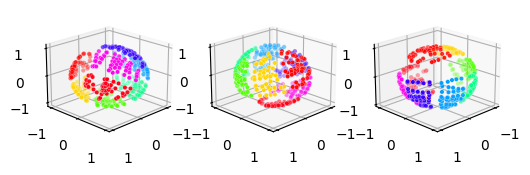

In [129]:
# (1m)
# setup figure
plt.set_cmap("hsv")  # circular cmap
SIZE = 10

fig = plt.figure(figsize=(6, 2))

# -------  plot full gt responses ---------

# note: we take all the responses so
# no source of variability
em, Cebra = get_embedding(
    response_full_gt,
    discrete_label,
    model_cfg,
    model_path_full_gt,
    train=TRAIN,
    save=SAVE,
    seed=0,
)
ax = fig.add_subplot(1, 3, 1, projection="3d")
plot_em(ax, em, discrete_label, size=SIZE)


# ------- plot subsampling yield responses ---------

# note: we sample the responses so
# embedding can change with response seed
em_rnd_k4, Cebra_rnd_k4 = get_embedding(
    response_rand_k4_yield,
    discrete_label,
    model_cfg,
    model_path_rand_k4,
    train=TRAIN,
    save=SAVE,
    seed=0,
)
ax = fig.add_subplot(1, 3, 2, projection="3d")
plot_em(ax, em_rnd_k4, discrete_label, size=SIZE)


# ------- plot ks4 subsampling bias responses ---------

# note: we sample the responses so
# embedding can change with response seed
em_bias_k4, Cebra_bias_k4 = get_embedding(
    response_biased_as_k4,
    discrete_label,
    model_cfg,
    model_path_bias_k4,
    train=TRAIN,
    save=SAVE,
    seed=0,
)
ax = fig.add_subplot(1, 3, 3, projection="3d")
plot_em(ax, em_bias_k4, discrete_label, size=SIZE)


# save
utils.savefig(
    proj_path + "/figures/4_code/fig7C_manifolds_vs_sampling.svg",
)

#### Information capacity

* SEED_GT = 5 is closest (1.292) to the full GT's mean capacity as calculated with the igeom pipeline (a seed is needed due to the shuffling procdure to calculate the lower bound).
* geometrics: {'capacity': 0.20491665061216288, 'radius': 0.75, 'dimensions': 12.2}

In [130]:
# (40s)
SEED_GT = 5

# calculate information capacity
# note : there is variability to due lower bound shuffling
# conzroled by the seed
ig_data = igeom.get_true_infogeometry(
    response_full_gt,
    discrete_label,
    SAMPLE_DIR,
    n_exple_per_class=n_exple_per_class,
    n_new=200,
    seed=SEED_GT,
    reduce_dim=True,
)
cap_full_gt = (
    ig_data["data"]["average_metrics"]["capacity"]
    / ig_data["shuffled"]["average_metrics"]["capacity"]
)
print("mean capacity:", cap_full_gt)
print("geometrics:", ig_data["data"]["average_metrics"])

2024-10-19 16:52:53,080 - root - igeom.py - analyse_class_manifolds - INFO - Done with dimensionality reduction before manifold analysis...
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +5.5401410330534446e+00    2.98526888e-01    
   2         +5.5140971220287396e+00    1.54380669e-01    
   3         +5.4967360570179276e+00    1.60030690e-01    
   4         +5.4716718479609217e+00    2.79176933e-01    
   5         +5.4488566720683149e+00    2.98961786e-01    
   6         +5.4221274267098014e+00    1.32300681e-01    
   7         +5.4138404661112389e+00    4.60425370e-02    
   8         +5.4127288808465392e+00    1.58890639e-02    
   9         +5.4125849037460458e+00    6.27504971e-03    
  10         +5.4125614200068073e+00    2.78791686e-03    
  11         +5.4125565762086829e+00    1.41062336e-03    
  12         +5.4125547339217164e+00    3.77331908e-04    
  13         +5.4125

* Hypothesis: Manifold capacity should be degraded and explained by increased radius, dimensions and correlation.
* SEED_rand_k4_yield = 6 is closest (xxxx) to the 1.25 mean for ks4.
* geometrics: {'capacity': 0.20491665061216288, 'radius': 0.75, 'dimensions': 12.2}


0: 1.18  
1: 1.34   
2: 1.22  
3: 1.19  
4: 1.28  
5: 1.30  
6: 1.249

behavior_pos: -0.7379 behavior_neg:  7.1586 behavior_total:  6.4208 time_pos: -0.7522 time_neg:  7.1586 time_total:  6.4065:   0%|          | 4/3000 [00:00<01:16, 39.38it/s]

behavior_pos: -8.7024 behavior_neg:  14.1104 behavior_total:  5.4080 time_pos: -9.8203 time_neg:  14.1104 time_total:  4.2901: 100%|██████████| 3000/3000 [01:00<00:00, 49.94it/s]


2024-10-19 16:54:49,999 - root - igeom.py - analyse_class_manifolds - INFO - Done with dimensionality reduction before manifold analysis...
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +5.5356441040230830e+00    3.64165309e-01    
   2         +5.5025675046482441e+00    1.77182818e-01    
   3         +5.4899302888634294e+00    8.16484568e-02    
   4         +5.4813748454474860e+00    1.29387831e-01    
   5         +5.4669483646505652e+00    2.84338756e-01    
   6         +5.4511587737217519e+00    3.22743808e-01    
   7         +5.4244018543248398e+00    1.91024527e-01    
   8         +5.4087589305695198e+00    6.20501688e-02    
   9         +5.4069696195787982e+00    2.38656616e-02    
  10         +5.4066807273987472e+00    1.21225892e-02    
  11         +5.4065649345128213e+00    2.64214691e-03    
  12         +5.4065614315272805e+00    1.35304496e-03    
  13         +5.4065

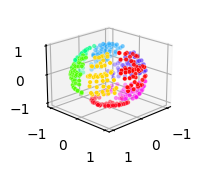

In [131]:
# (1m)
# reproducibility
SEED_rand_k4_yield = 6

# sample units uniformly to mimick k4 yield
response_rand_k4_yield = sample_units_randomly_to_match_sorter_yield(
    "KS4", response_full_gt, seed=SEED_rand_k4_yield
)

# ------- plot subsampling yield responses ---------

em_rnd_k4, Cebra_rnd_k4 = get_embedding(
    response_rand_k4_yield,
    discrete_label,
    model_cfg,
    model_path_rand_k4,
    train=TRAIN,
    save=SAVE,
    seed=0,
)

fig = plt.figure(figsize=(6, 2))

ax = fig.add_subplot(1, 3, 2, projection="3d")
plot_em(ax, em_rnd_k4, discrete_label, size=SIZE)

# calculate information capacity
ig_data_rand_k4_yield = igeom.get_infogeometry_for_sorter(
    response_rand_k4_yield,
    discrete_label,
    SAMPLE_DIR,
    n_exple_per_class=n_exple_per_class,
    n_new=200,
    seed=SEED_rand_k4_yield,
    reduce_dim=True,
)
cap_rand_k4_yield = (
    ig_data_rand_k4_yield["data"]["average_metrics"]["capacity"]
    / ig_data_rand_k4_yield["shuffled"]["average_metrics"]["capacity"]
)
print("mean capacity:", cap_rand_k4_yield)
print("geometrics:", ig_data_rand_k4_yield["data"]["average_metrics"])

* target mean capacity = 1.18
* SEED_biased_as_k4

0: 1.20

In [134]:
# (1m)
# reproducibility
SEED_biased_as_k4 = 1

# sample units to mimick k4 unit type sampling bias and yield
response_biased_as_k4 = sample_units_to_match_sorter_sampling_bias(
    "KS4", response_full_gt, K4, GT, DT, seed=SEED_biased_as_k4
)
# ------- plot subsampling yield responses ---------

# note: we sample the responses so
# embedding can change with response seed
em_bias_k4, Cebra_bias_k4 = get_embedding(
    response_biased_as_k4,
    discrete_label,
    model_cfg,
    model_path_bias_k4,
    train=TRAIN,
    save=SAVE,
    seed=0,
)
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(1, 3, 3, projection="3d")
plot_em(ax, em_bias_k4, discrete_label, size=SIZE)

# calculate information capacity
ig_data_biased_as_k4 = igeom.get_infogeometry_for_sorter(
    response_biased_as_k4,
    discrete_label,
    SAMPLE_DIR,
    n_exple_per_class=n_exple_per_class,
    n_new=200,
    seed=SEED_biased_as_k4,
    reduce_dim=True,
)
cap_biased_as_k4 = (
    ig_data_biased_as_k4["data"]["average_metrics"]["capacity"]
    / ig_data_biased_as_k4["shuffled"]["average_metrics"]["capacity"]
)
print("mean capacity:", cap_biased_as_k4)
print("geometrics:", ig_data_biased_as_k4["data"]["average_metrics"])

behavior_pos: -3.0741 behavior_neg:  8.5158 behavior_total:  5.4417 time_pos: -3.3886 time_neg:  8.5158 time_total:  5.1272:  39%|███▊      | 1159/3000 [00:20<00:38, 47.95it/s]

### Kilosort sorted responses

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/envs/cebra_manifold/lib/python3.9/site-packages/cebra/integrations/sklearn/cebra.py:1436: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to th

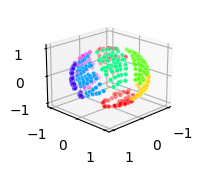

In [44]:
# pipeline parameters
TRAIN = False
SAVE = False


fig = plt.figure(figsize=(6, 2))

# ------- plot ks4 responses ---------

em_k4, Cebra_k4 = get_embedding(
    response_k4,
    discrete_label,
    model_cfg,
    model_path_k4,
    train=TRAIN,
    save=SAVE,
    seed=0,
)
ax = fig.add_subplot(1, 3, 3, projection="3d")
plot_em(ax, em_k4, discrete_label, size=SIZE)

# save
utils.savefig(
    proj_path + "/figures/4_code/fig7C_k4_manifold.svg",
)

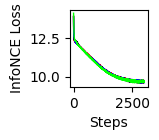

In [43]:
# -------  plot losses --------------------

fig, ax = plt.subplots(1, 1, figsize=(1, 1))
ax = cebra.plot_loss(ax=ax, model=Cebra, color=[1, 0, 0])
ax = cebra.plot_loss(ax=ax, model=Cebra_rnd_k4, color=[0, 0, 0])
ax = cebra.plot_loss(ax=ax, model=Cebra_bias_k4, color=[0, 0, 1])
ax = cebra.plot_loss(ax=ax, model=Cebra_k4, color=[0, 1, 0])

# save
utils.savefig(proj_path + "/figures/4_code/fig7C_manifolds_vs_sampling_losses.svg")

### PCA manifold

manifold axis max: 1.0
manifold axis min: -0.7966350987166639


{'manifold': array([[-0.16015689, -0.47552856,  1.        ],
        [-0.30931046, -0.15320078,  0.10180186],
        [-0.31601912, -0.15819906,  0.11860175],
        ...,
        [-0.2967791 ,  0.08864445,  0.14588603],
        [-0.21070931, -0.02185638,  0.15085114],
        [-0.27306035,  0.00449998,  0.12110679]]),
 'ax': <Axes3D: xlabel='Neural latent 1', ylabel='Neural latent 2', zlabel='Neural latent 3'>}

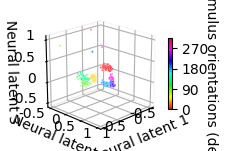

In [132]:
# set parameters
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(1, 3, 1, projection="3d")

# full ground truth
params = {"orientations": discrete_label}
params_pca = {
    "dims": 3,  # dimensions
    "orientations": params["orientations"],  # stimulus orientations
}
plot_manifold_from_pca(response, params_pca, ax, axis_lim=[-0.6, 1.1])

## Plot manifolds

### (20s) Single-units

* all 360 whisker deflection directions are represented
* that is the best output produced by the spike sorters

manifold axis max: 1.0
manifold axis min: -0.5180597493694815
manifold axis max: 1.0
manifold axis min: -0.28716006805205607
manifold axis max: 1.0
manifold axis min: -0.4405711461379888
manifold axis max: 1.0
manifold axis min: -0.332104220007866
manifold axis max: 1.0
manifold axis min: -0.37325327083610715
manifold axis max: 1.0
manifold axis min: -0.24925116509322112
manifold axis max: 1.0
manifold axis min: -0.44878083070067937


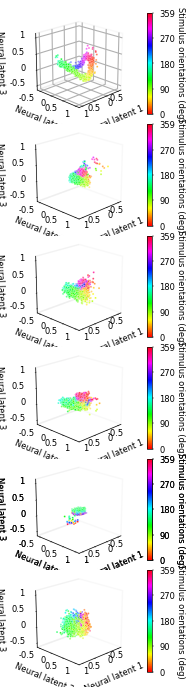

In [4]:
# plot
fig = plt.figure(figsize=FIG_SIZE)

# panel 1: ground truth
ax = fig.add_subplot(N_PANELS, 1, 1, projection="3d")
manifold = igeom.plot_manifold_from_pca(gt_resp, params_pca, ax, axis_lim=[-0.6, 1.1])

# panels 2 to 4: loop over sorters (w/ single-unit curation)
# record
# sorters name are standardized as in the quality table
# loaded below
sorter = ["KS4", "KS3", "KS2.5", "KS2"]

# plot
out_data = dict()
c_ix = 0
for s_ix, Sorting in enumerate(sortingextractors1, start=2):
    ax = fig.add_subplot(N_PANELS, 1, s_ix, projection="3d")
    out_data[sorter[c_ix]] = igeom.plot_sorted_manifolds2(
        ax, Sorting, stimulus_intervals_ms, params_pca, axis_lim=[-0.6, 1.1]
    )
    c_ix += 1
    ax.grid(False)

# panels 5 and 6: loop over KS and HS (no single-unit curation)
# record
sorter = ["KS", "HS"]

# plot
c_ix = 0
for s_ix, Sorting in enumerate(sortingextractors2, start=5):
    ax = fig.add_subplot(N_PANELS, 1, s_ix, projection="3d")
    out_data[sorter[c_ix]] = igeom.plot_all_sorted_unit_manifolds2(
        ax, Sorting, stimulus_intervals_ms, params_pca, axis_lim=[-0.6, 1.1]
    )
    c_ix += 1
    ax.grid(False)

# tidy up
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# save figure
utils.savefig(PROJ_PATH + "/figures/4_code/single_unit_manifolds.svg")